# Basic Text Classification with Naive Bayes
***
In the mini-project, you'll learn the basics of text analysis using a subset of movie reviews from the rotten tomatoes database. You'll also use a fundamental technique in Bayesian inference, called Naive Bayes. This mini-project is based on [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class.  Please free to go to the original lab for additional exercises and solutions.

In [5]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

# Table of Contents

* [Rotten Tomatoes Dataset](#Rotten-Tomatoes-Dataset)
    * [Explore](#Explore)
* [The Vector Space Model and a Search Engine](#The-Vector-Space-Model-and-a-Search-Engine)
    * [In Code](#In-Code)
* [Naive Bayes](#Naive-Bayes)
    * [Multinomial Naive Bayes and Other Likelihood Functions](#Multinomial-Naive-Bayes-and-Other-Likelihood-Functions)
    * [Picking Hyperparameters for Naive Bayes and Text Maintenance](#Picking-Hyperparameters-for-Naive-Bayes-and-Text-Maintenance)
* [Interpretation](#Interpretation)


## Rotten Tomatoes Dataset

In [6]:
critics = pd.read_csv('./critics.csv')
for name in enumerate(critics.columns):
    print(name)
#print(critics)
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics

(0, 'critic')
(1, 'fresh')
(2, 'imdb')
(3, 'publication')
(4, 'quote')
(5, 'review_date')
(6, 'rtid')
(7, 'title')


,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story
6,Michael Booth,fresh,114709,Denver Post,"As Lion King did before it, Toy Story revived ...",2007-05-03,9559,Toy story
7,Geoff Andrew,fresh,114709,Time Out,The film will probably be more fully appreciat...,2006-06-24,9559,Toy story
8,Janet Maslin,fresh,114709,New York Times,Children will enjoy a new take on the irresist...,2003-05-20,9559,Toy story
9,Kenneth Turan,fresh,114709,Los Angeles Times,Although its computer-generated imagery is imp...,2001-02-13,9559,Toy story
10,Susan Wloszczyna,fresh,114709,USA Today,How perfect that two of the most popular funny...,2000-01-01,9559,Toy story


### Explore

In [7]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size


print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


In [8]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'


In [9]:
grp = df.groupby('critic')
print(df.critic.value_counts())

Roger Ebert            1132
James Berardinelli      804
Janet Maslin            515
Variety Staff           430
Jonathan Rosenbaum      412
Desson Thomson          391
Geoff Andrew            349
Dave Kehr               338
Kenneth Turan           279
Mick LaSalle            273
Peter Travers           258
Owen Gleiberman         247
Rita Kempley            244
Mike Clark              231
Joe Baltake             228
Todd McCarthy           221
Vincent Canby           217
Hal Hinson              183
Susan Stark             175
Stephen Holden          167
Jeff Millar             164
Michael Wilmington      162
Derek Adams             151
Kevin Thomas            145
Bosley Crowther         141
Peter Stack             137
Susan Wloszczyna        132
Rick Groen              125
Richard Schickel        122
Edward Guthmann         119
                       ... 
Simon Houpt               1
Joshua Land               1
Russell Edwards           1
Joey Guerra               1
Francis X. Clines   

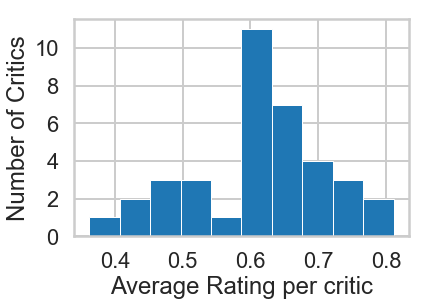

In [10]:
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic
avge = means[counts > 100]
means[counts > 100].hist(bins=10, edgecolor='w', lw=1)

plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);

In [11]:
avge.describe()

count    37.000000
mean      0.612399
std       0.102129
min       0.362069
25%       0.554878
50%       0.615894
75%       0.673145
max       0.811404
Name: fresh, dtype: float64

<div class="span5 alert alert-info">
<h3>Exercise Set I</h3>
<br/>
<b>Exercise:</b> Look at the histogram above. Tell a story about the average ratings per critic. What shape does the distribution look like? What is interesting about the distribution? What might explain these interesting things?
</div>
Answer: It is interesting that the the majority of critics who have done over 100 reviews give a positive rating between 60 and 70 percent of the time. It is also intesting that most reviewers on average give more fresh than rotten reviews. This can be seen in that even the twenty-fifth percentile has an average freshness score of .55. and them maximum percent of positive reviews is 81 percent.

All of this indicates that there is relative similarity on the percentage of positive reviews for critics given over 100 reviews. Additionally this is shown in that the standard deviation is only 10%. This could be explained in that critics would be seen as negative and bias if they consistantly rank movies negatively. One possible explanation is that critics' success may  be contigent on having reasonably positive reviews. If a critic only panned movies it could be detrimental to his career. Also, if somebody chooses to rank movies professionally you would think that they overall enjoy watching movies. Finally critics may be invited to screen movies when they give more positive ratings than negative ones. 

Also, the fact that the max mean fresh score of a critic is .81 indicates that a critic must also be willing to share some level of critique to be successful and not seen as bias. One's opinion would not be considered reliable if all movies they saw were rated positively.

All the diagrams here are snipped from [*Introduction to Information Retrieval* by Manning et. al.]( http://nlp.stanford.edu/IR-book/) which is a great resource on text processing. For additional information on text mining and natural language processing, see [*Foundations of Statistical Natural Language Processing* by Manning and Schutze](http://nlp.stanford.edu/fsnlp/).

Also check out Python packages [`nltk`](http://www.nltk.org/), [`spaCy`](https://spacy.io/), [`pattern`](http://www.clips.ua.ac.be/pattern), and their associated resources. Also see [`word2vec`](https://en.wikipedia.org/wiki/Word2vec).

Let us define the vector derived from document $d$ by $\bar V(d)$. What does this mean? Each document is treated as a vector containing information about the words contained in it. Each vector has the same length and each entry "slot" in the vector contains some kind of data about the words that appear in the document such as presence/absence (1/0), count (an integer) or some other statistic. Each vector has the same length because each document shared the same vocabulary across the full collection of documents -- this collection is called a *corpus*.

To define the vocabulary, we take a union of all words we have seen in all documents. We then just associate an array index with them. So "hello" may be at index 5 and "world" at index 99.

Suppose we have the following corpus:

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree. The grapes seemed ready to burst with juice, and the Fox's mouth watered as he gazed longingly at them.`

Suppose we treat each sentence as a document $d$. The vocabulary (often called the *lexicon*) is the following:

$V = \left\{\right.$ `a, along, and, as, at, beautiful, branches, bunch, burst, day, fox, fox's, from, gazed, grapes, hanging, he, juice, longingly, mouth, of, one, ready, ripe, seemed, spied, the, them, to, trained, tree, vine, watered, with`$\left.\right\}$

Then the document

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree`

may be represented as the following sparse vector of word counts:

$$\bar V(d) = \left( 4,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,2,1,0,1,0,0,1,0,0,1,1,1,0,0 \right)$$

or more succinctly as

`[(0, 4), (1, 1), (5, 1), (6, 1), (7, 1), (9, 1), (10, 1), (12, 1), (14, 1), (15, 1), (20, 2), (21, 1), (23, 1),`
`(26, 1), (29,1), (30, 1), (31, 1)]`

along with a dictionary

``
{
    0: a, 1: along, 5: beautiful, 6: branches, 7: bunch, 9: day, 10: fox, 12: from, 14: grapes, 15: hanging, 19: mouth, 20: of, 21: one, 23: ripe, 24: seemed, 25: spied, 26: the, 29:trained, 30: tree, 31: vine, 
}
``

Then, a set of documents becomes, in the usual `sklearn` style, a sparse matrix with rows being sparse arrays representing documents and columns representing the features/words in the vocabulary.

Notice that this representation loses the relative ordering of the terms in the document. That is "cat ate rat" and "rat ate cat" are the same. Thus, this representation is also known as the Bag-Of-Words representation.

Here is another example, from the book quoted above, although the matrix is transposed here so that documents are columns:

![novel terms](terms.png)

Such a matrix is also catted a Term-Document Matrix. Here, the terms being indexed could be stemmed before indexing; for instance, `jealous` and `jealousy` after stemming are the same feature. One could also make use of other "Natural Language Processing" transformations in constructing the vocabulary. We could use Lemmatization, which reduces words to lemmas: work, working, worked would all reduce to work. We could remove "stopwords" from our vocabulary, such as common words like "the". We could look for particular parts of speech, such as adjectives. This is often done in Sentiment Analysis. And so on. It all depends on our application.

From the book:
>The standard way of quantifying the similarity between two documents $d_1$ and $d_2$  is to compute the cosine similarity of their vector representations $\bar V(d_1)$ and $\bar V(d_2)$:

$$S_{12} = \frac{\bar V(d_1) \cdot \bar V(d_2)}{|\bar V(d_1)| \times |\bar V(d_2)|}$$

![Vector Space Model](vsm.png)


>There is a far more compelling reason to represent documents as vectors: we can also view a query as a vector. Consider the query q = jealous gossip. This query turns into the unit vector $\bar V(q)$ = (0, 0.707, 0.707) on the three coordinates below. 

![novel terms](terms2.png)

>The key idea now: to assign to each document d a score equal to the dot product:

$$\bar V(q) \cdot \bar V(d)$$

Then we can use this simple Vector Model as a Search engine.

### In Code

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)
y = x.tocsc()
print(f'this is y:{y}')
# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
print(f'this is x:{x}')

Original text is
Hop on pop
Hop off pop
Hop Hop hop
this is y:  (0, 0)	1
  (1, 0)	1
  (2, 0)	3
  (1, 1)	1
  (0, 2)	1
  (0, 3)	1
  (1, 3)	1
this is x:  (0, 0)	1
  (0, 2)	1
  (0, 3)	1
  (1, 0)	1
  (1, 1)	1
  (1, 3)	1
  (2, 0)	3


In [13]:
x = x.toarray()
print(x)

[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]


In [14]:

print("")
print("Transformed text vector is \n{}".format(x))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequenc


Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
['hop', 'off', 'on', 'pop']


In [15]:
print(type(critics.quote))

<class 'pandas.core.series.Series'>


In [16]:
    vctr = CountVectorizer()
    #critics_quote = np.array(critics.quote)
    train_fit = vctr.fit_transform(critics.quote)#.apply(lambda row: ' '.join(row))
    

In [17]:
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X,y

X, y = make_xy(critics)
print(X.shape)
print(type(X))
print(X[:5])


(15561, 22417)
<class 'scipy.sparse.csc.csc_matrix'>
  (4, 139)	1
  (3, 374)	1
  (2, 595)	1
  (4, 757)	1
  (4, 863)	1
  (0, 891)	2
  (3, 891)	1
  (2, 939)	1
  (4, 942)	1
  (3, 1049)	1
  (0, 1767)	1
  (3, 2074)	1
  (0, 2784)	1
  (4, 3058)	1
  (0, 3248)	1
  (1, 3835)	1
  (4, 3983)	1
  (0, 4003)	1
  (0, 4386)	1
  (0, 5251)	1
  (4, 6211)	1
  (0, 6494)	1
  (4, 6556)	1
  (3, 6617)	1
  (3, 6754)	1
  :	:
  (0, 14940)	1
  (3, 15409)	1
  (0, 17231)	1
  (0, 17943)	1
  (0, 18252)	1
  (2, 18347)	1
  (2, 18505)	1
  (3, 18626)	1
  (0, 18757)	1
  (0, 18904)	1
  (3, 18970)	1
  (3, 19760)	1
  (0, 19914)	1
  (2, 19914)	1
  (3, 19914)	1
  (4, 19914)	1
  (1, 19917)	1
  (2, 19917)	1
  (3, 19917)	2
  (3, 19995)	1
  (4, 20337)	1
  (0, 21732)	1
  (2, 22051)	1
  (1, 22292)	1
  (0, 22330)	1


## Naive Bayes

From Bayes' Theorem, we have that

$$P(c \vert f) = \frac{P(c \cap f)}{P(f)}$$

where $c$ represents a *class* or category, and $f$ represents a feature vector, such as $\bar V(d)$ as above. **We are computing the probability that a document (or whatever we are classifying) belongs to category *c* given the features in the document.** $P(f)$ is really just a normalization constant, so the literature usually writes Bayes' Theorem in context of Naive Bayes as

$$P(c \vert f) \propto P(f \vert c) P(c) $$

$P(c)$ is called the *prior* and is simply the probability of seeing class $c$. But what is $P(f \vert c)$? This is the probability that we see feature set $f$ given that this document is actually in class $c$. This is called the *likelihood* and comes from the data. One of the major assumptions of the Naive Bayes model is that the features are *conditionally independent* given the class. While the presence of a particular discriminative word may uniquely identify the document as being part of class $c$ and thus violate general feature independence, conditional independence means that the presence of that term is independent of all the other words that appear *within that class*. This is a very important distinction. Recall that if two events are independent, then:

$$P(A \cap B) = P(A) \cdot P(B)$$

Thus, conditional independence implies

$$P(f \vert c)  = \prod_i P(f_i | c) $$

where $f_i$ is an individual feature (a word in this example).

To make a classification, we then choose the class $c$ such that $P(c \vert f)$ is maximal.

There is a small caveat when computing these probabilities. For [floating point underflow](http://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html) we change the product into a sum by going into log space. This is called the LogSumExp trick. So:

$$\log P(f \vert c)  = \sum_i \log P(f_i \vert c) $$

There is another caveat. What if we see a term that didn't exist in the training data? This means that $P(f_i \vert c) = 0$ for that term, and thus $P(f \vert c)  = \prod_i P(f_i | c) = 0$, which doesn't help us at all. Instead of using zeros, we add a small negligible value called $\alpha$ to each count. This is called Laplace Smoothing.

$$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$

where $N_{ic}$ is the number of times feature $i$ was seen in class $c$, $N_c$ is the number of times class $c$ was seen and $N_i$ is the number of times feature $i$ was seen globally. $\alpha$ is sometimes called a regularization parameter.

### Multinomial Naive Bayes and Other Likelihood Functions

Since we are modeling word counts, we are using variation of Naive Bayes called Multinomial Naive Bayes. This is because the likelihood function actually takes the form of the multinomial distribution.

$$P(f \vert c) = \frac{\left( \sum_i f_i \right)!}{\prod_i f_i!} \prod_{f_i} P(f_i \vert c)^{f_i} \propto \prod_{i} P(f_i \vert c)$$

where the nasty term out front is absorbed as a normalization constant such that probabilities sum to 1.

There are many other variations of Naive Bayes, all which depend on what type of value $f_i$ takes. If $f_i$ is continuous, we may be able to use *Gaussian Naive Bayes*. First compute the mean and variance for each class $c$. Then the likelihood, $P(f \vert c)$ is given as follows

$$P(f_i = v \vert c) = \frac{1}{\sqrt{2\pi \sigma^2_c}} e^{- \frac{\left( v - \mu_c \right)^2}{2 \sigma^2_c}}$$

<div class="span5 alert alert-info">
<h3>Exercise Set II</h3>

<p><b>Exercise:</b> Implement a simple Naive Bayes classifier:</p>

<ol>
<li> split the data set into a training and test set
<li> Use `scikit-learn`'s `MultinomialNB()` classifier with default parameters.
<li> train the classifier over the training set and test on the test set
<li> print the accuracy scores for both the training and the test sets
</ol>

What do you notice? Is this a good classifier? If not, why not?
</div>

In [38]:
y = (critics.fresh == 'fresh').values.astype(np.int)

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .40, random_state= 35)
MNB = MultinomialNB()

MNB.fit( X_train, y_train)
y_pred = MNB.predict(X_test)
print(f'x test shape:{X_test.shape}')
print(f'x train shape:{X_train.shape}')

y_train_pred= MNB.predict(X_train)
score_test = metrics.accuracy_score(y_test, y_pred)
print()
print(f'test set score:{score_test}')
train_score = metrics.accuracy_score(y_train, y_train_pred)
print(f'train set score:{train_score}')
for z, h in zip(y_train, y_train_pred):
    print(z, h)

x test shape:(6225, 1730)
x train shape:(9336, 1730)

test set score:0.7323694779116466
train set score:0.7864181662382177
1 1
0 0
0 1
1 1
0 1
0 1
0 1
0 0
0 1
1 1
1 0
0 0
1 1
1 1
0 0
1 1
1 1
1 1
0 0
1 1
0 0
1 0
0 0
1 1
1 1
0 1
0 1
1 1
1 1
1 1
1 0
1 1
0 0
1 1
1 1
0 0
0 1
1 1
1 0
1 1
0 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 0
0 0
0 1
1 1
1 0
1 1
1 1
0 0
1 1
0 1
1 1
0 0
0 1
1 0
0 0
0 0
1 1
0 0
1 1
1 1
0 1
1 1
1 1
0 0
1 1
1 1
1 1
1 1
0 1
1 0
0 0
1 1
0 1
1 1
0 1
0 0
1 1
1 0
1 1
0 1
1 1
0 1
0 0
1 1
1 0
1 0
1 1
1 1
1 1
1 1
0 0
1 1
0 0
1 1
0 1
1 1
1 1
1 0
0 1
0 0
0 0
1 1
1 1
1 1
0 0
1 1
0 0
1 1
1 1
1 1
0 0
1 1
1 1
0 1
0 1
1 1
1 1
1 1
1 1
1 1
0 0
1 1
1 1
0 1
1 1
1 1
1 1
0 0
1 0
1 0
0 1
0 1
1 1
0 0
1 1
0 0
0 0
0 0
1 1
0 0
0 1
1 1
1 1
1 0
1 1
1 1
1 1
0 1
1 1
1 0
1 1
1 1
0 0
1 0
0 1
1 1
0 0
0 1
0 0
1 0
1 1
1 1
0 0
1 1
1 1
0 1
1 1
0 0
1 1
0 0
0 0
1 1
1 1
1 1
0 0
1 1
1 1
1 1
1 1
0 0
1 1
1 1
1 0
0 0
0 0
0 1
1 1
0 1
1 1
1 0
0 0
0 0
0 1
0 0
0 0
0 0
0 0
1 1
1 1
0 0
1 1
0 0
0 0
1 1
1 0
0 0
0 0
1 1
0 0
0 0
1 1
1

0 1
0 0
1 0
1 1
1 1
0 0
0 0
1 1
0 1
1 0
1 1
1 1
0 0
0 0
1 1
0 0
1 0
0 0
1 1
0 1
0 0
1 1
1 1
0 0
1 1
0 1
1 0
0 1
1 1
1 1
0 0
1 1
1 1
0 1
0 0
1 1
1 1
1 1
0 0
1 1
0 0
1 0
0 0
0 0
0 1
1 1
0 1
1 1
1 1
1 1
1 1
0 0
1 1
1 1
0 1
1 1
1 1
0 1
0 0
1 1
0 0
0 0
1 1
0 0
0 0
1 1
1 1
0 0
1 1
1 1
0 0
0 0
0 0
1 1
1 1
0 1
1 0
0 0
0 0
1 1
1 1
0 0
0 0
1 1
1 1
0 0
1 1
1 1
1 1
1 1
0 1
0 0
1 1
0 0
1 1
1 1
1 1
1 1
0 1
1 1
0 1
0 0
1 1
1 1
1 1
1 1
1 1
0 0
0 0
1 1
1 1
0 0
1 1
0 1
1 0
0 0
0 1
1 1
0 0
0 0
0 0
0 0
0 0
1 1
1 1
1 1
1 1
0 0
1 1
1 1
1 1
1 0
1 1
1 1
1 0
1 1
1 1
1 1
0 0
1 1
1 1
1 1
0 1
1 1
1 0
1 0
1 1
1 0
1 1
1 1
0 0
1 0
0 0
1 0
1 1
1 1
0 0
0 0
0 1
0 0
1 1
1 1
0 0
0 0
1 1
1 1
0 0
1 1
0 0
0 0
1 0
1 1
0 1
0 0
0 0
1 1
0 0
0 1
1 1
1 1
1 1
1 1
1 1
0 0
1 1
0 0
1 1
0 0
0 0
1 1
1 0
1 1
0 0
1 1
1 1
1 1
0 0
1 1
1 0
1 0
0 1
1 1
1 1
0 0
1 1
0 0
1 1
1 1
1 0
1 1
0 0
1 1
1 1
1 1
0 0
1 1
1 1
1 1
1 1
1 1
0 0
0 1
1 1
1 1
1 1
1 0
1 1
0 0
1 1
0 1
1 0
0 1
1 1
0 1
1 1
1 0
0 1
1 0
1 1
0 0
0 0
1 1
0 1
0 0
0 0
0 0
0 1
1 0
1 1
1 1


0 1
1 1
1 1
1 1
1 1
0 1
0 0
1 1
1 0
1 0
1 1
0 1
1 1
0 1
1 1
1 1
1 1
1 1
0 1
0 0
0 0
1 1
0 0
1 0
0 1
1 1
1 1
1 1
1 1
0 1
1 1
1 1
0 0
1 0
1 1
0 0
1 1
0 0
1 1
0 1
1 1
0 0
0 0
1 1
1 1
1 1
0 1
1 1
1 1
0 0
1 1
1 1
0 1
0 0
1 1
0 0
0 0
0 1
0 0
1 1
0 1
1 1
0 0
1 0
1 1
0 0
1 1
0 0
1 1
1 1
0 0
1 0
1 1
1 0
1 1
0 0
1 1
0 0
1 1
0 1
0 0
1 1
1 1
1 0
1 1
1 1
1 1
1 0
1 1
0 0
1 1
1 1
1 0
0 1
1 1
1 0
1 1
1 1
1 1
0 1
1 1
1 1
0 0
1 1
1 1
0 0
1 0
1 1
1 1
1 1
1 1
0 0
1 1
1 1
0 1
0 0
1 1
1 1
1 1
1 1
0 0
0 1
0 0
0 0
1 1
0 1
1 0
1 1
1 1
0 0
1 1
0 1
0 1
1 1
1 1
1 1
1 1
0 1
1 1
0 0
0 1
1 1
1 1
0 1
1 1
1 0
1 1
1 1
1 0
1 1
0 0
0 1
0 0
1 1
1 1
1 1
0 0
1 1
0 0
1 1
1 1
0 0
1 1
1 1
1 1
0 0
1 0
0 0
1 1
0 1
1 0
1 1
1 1
1 1
0 1
1 1
1 1
0 0
1 0
1 1
1 1
1 1
1 0
1 0
0 0
1 1
1 1
1 1
0 0
1 1
1 1
0 0
1 0
1 1
1 1
1 1
0 0
0 1
1 1
1 1
1 1
1 0
0 0
1 0
1 1
0 0
1 1
1 1
1 1
1 0
0 0
1 1
1 0
1 1
1 1
1 1
1 1
1 1
1 0
0 1
1 1
1 1
1 1
0 1
1 1
1 1
0 1
1 1
0 0
0 0
0 1
1 0
1 1
1 1
1 1
1 1
1 1
1 1
0 0
1 1
0 0
1 1
1 1
1 1
0 1
1 1
0 0
1 1
0 0
1 1


1 0
1 1
1 1
1 1
0 1
0 0
0 1
1 1
0 1
1 1
1 1
0 1
1 1
1 1
0 0
1 1
1 1
1 1
1 1
0 0
1 1
1 0
1 1
0 0
1 1
1 1
0 0
1 1
1 0
0 0
1 1
1 1
1 1
1 1
1 1
0 0
0 0
1 1
1 1
0 0
0 0
0 0
1 0
1 1
0 0
0 0
1 0
1 1
1 1
1 1
0 0
1 1
0 0
1 1
0 0
0 1
1 1
1 1
1 0
1 1
1 1
0 0
1 0
0 1
0 0
1 1
1 1
0 0
1 1
1 0
0 0
1 0
1 1
1 1
0 0
1 1
1 1
1 1
1 1
1 1
1 0
0 1
1 1
1 1
0 1
0 0
1 1
1 1
0 1
1 1
1 1
1 1
0 0
0 0
0 0
0 1
1 1
1 1
1 1
0 1
0 0
0 0
1 1
1 1
1 1
0 1
0 1
0 1
1 0
0 0
1 1
1 1
1 1
0 0
1 0
0 0
0 0
1 1
0 0
0 1
1 1
1 0
1 1
1 1
0 0
1 1
0 0
1 1
1 1
1 1
1 1
0 1
0 0
0 0
0 1
0 0
1 1
1 0
0 0
0 0
0 0
0 0
1 1
0 0
0 0
1 0
0 1
1 1
1 0
1 1
0 0
0 0
1 1
0 0
0 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 0
0 0
0 0
0 0
0 0
0 0
1 1
1 1
0 0
1 1
0 0
1 1
1 1
1 0
1 1
1 0
1 0
1 1
1 1
1 1
1 1
0 0
1 1
0 1
1 1
1 1
1 1
0 0
0 0
0 1
1 1
0 0
1 1
1 1
0 1
0 0
0 0
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 0
0 1
1 1
1 1
1 1
1 1
1 1
1 1
0 1
0 1
0 0
0 0
1 1
1 1
0 1
0 0
1 1
1 1
1 1
1 1
1 1
1 0
1 1
0 1
0 0
1 1
0 0
1 1
1 1
1 0
1 0
1 0
1 1
1 1
1 1
0 0
1 1
1 1
0 0
0 0
1 1
1 1
1 1
1 1


As a straight out of the box classifier this classifier works well with the dataset. The fact that the training set outperformed the test set is typical since it was fit to the training set. 

### Picking Hyperparameters for Naive Bayes and Text Maintenance

We need to know what value to use for $\alpha$, and we also need to know which words to include in the vocabulary. As mentioned earlier, some words are obvious stopwords. Other words appear so infrequently that they serve as noise, and other words in addition to stopwords appear so frequently that they may also serve as noise.

First, let's find an appropriate value for `min_df` for the `CountVectorizer`. `min_df` can be either an integer or a float/decimal. If it is an integer, `min_df` represents the minimum number of documents a word must appear in for it to be included in the vocabulary. If it is a float, it represents the minimum *percentage* of documents a word must appear in to be included in the vocabulary. From the documentation:

>min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

<div class="span5 alert alert-info">
<h3>Exercise Set III</h3>

<p><b>Exercise:</b> Construct the cumulative distribution of document frequencies (df). The $x$-axis is a document count $x_i$ and the $y$-axis is the percentage of words that appear less than $x_i$ times. For example, at $x=5$, plot a point representing the percentage or number of words that appear in 5 or fewer documents.</p>

<p><b>Exercise:</b> Look for the point at which the curve begins climbing steeply. This may be a good value for `min_df`. If we were interested in also picking `max_df`, we would likely pick the value where the curve starts to plateau. What value did you choose?</p>
</div>

In [19]:
print(X)

  (1028, 0)	1
  (3215, 0)	1
  (4740, 0)	1
  (4741, 0)	1
  (8722, 0)	2
  (8820, 0)	1
  (12118, 0)	1
  (4031, 1)	1
  (74, 2)	1
  (76, 2)	1
  (3653, 2)	1
  (4031, 2)	1
  (8023, 2)	1
  (10704, 2)	1
  (13425, 2)	1
  (13435, 2)	1
  (13668, 2)	1
  (13693, 2)	1
  (8647, 3)	1
  (369, 4)	1
  (24, 5)	1
  (65, 5)	1
  (472, 5)	1
  (625, 5)	1
  (731, 5)	1
  :	:
  (14548, 22402)	1
  (14551, 22402)	1
  (958, 22403)	1
  (10209, 22403)	1
  (6804, 22404)	1
  (8594, 22405)	1
  (14697, 22406)	1
  (6465, 22407)	1
  (4134, 22408)	1
  (8145, 22408)	1
  (4471, 22409)	1
  (4477, 22409)	1
  (4478, 22409)	1
  (4476, 22410)	1
  (8847, 22411)	1
  (1076, 22412)	1
  (3126, 22412)	1
  (3128, 22412)	1
  (9252, 22412)	1
  (2774, 22413)	1
  (3360, 22414)	1
  (5930, 22414)	1
  (10457, 22414)	1
  (4473, 22415)	1
  (8518, 22416)	1


[[ 8]
 [ 1]
 [10]
 [ 1]
 [ 1]
 [39]
 [17]
 [ 4]
 [ 1]
 [ 1]]
        0
0       8
1       1
2      10
3       1
4       1
5      39
6      17
7       4
8       1
9       1
10      1
11      2
12      2
13      9
14      3
15      2
16      1
17      1
18      2
19      1
20     12
21      2
22      3
23      2
24     14
25      1
26      1
27      1
28      1
29      1
...    ..
22387   1
22388   3
22389   4
22390   1
22391   4
22392   1
22393   1
22394   5
22395   1
22396   1
22397   4
22398  10
22399   3
22400   1
22401   1
22402  13
22403   2
22404   1
22405   1
22406   1
22407   1
22408   2
22409   3
22410   1
22411   1
22412   4
22413   1
22414   3
22415   1
22416   1

[22417 rows x 1 columns]
value counts: 1       159
2        34
3        24
4        12
5         9
10        5
6         5
11        5
17        4
20        3
7         3
12        3
8         3
48        2
18        2
53        2
21        2
13        2
19        1
532       1
14        1
23        1
25        1
35 

Text(0.5, 1.0, 'Cumulative distribution of document frequencies (df)')

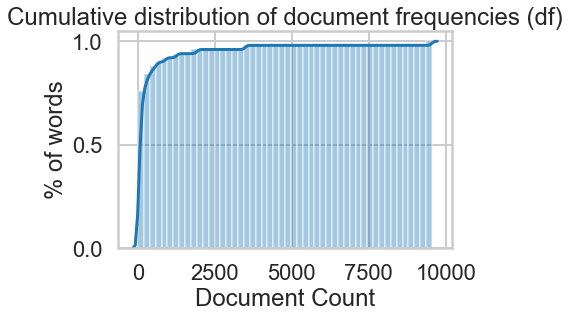

In [20]:


distrib = X.sum(axis=0)

distrib = distrib.transpose()
print(distrib[:10])
#print(type(distrib))
doc_df = pd.DataFrame(data=distrib)
print(doc_df)
#print doc_df.head(10)
doc_gb = doc_df.groupby(0).size()
print(f'value counts: {doc_gb.value_counts()}')
print(doc_gb.head(10))
sns.distplot(
    doc_gb.head(50), hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True))
plt.xlabel('Document Count')
plt.ylabel('% of words')
plt.title('Cumulative distribution of document frequencies (df)')



For min_df, I estimated the curve begins to climb steeply between 100 and 150.

The parameter $\alpha$ is chosen to be a small value that simply avoids having zeros in the probability computations. This value can sometimes be chosen arbitrarily with domain expertise, but we will use K-fold cross validation. In K-fold cross-validation, we divide the data into $K$ non-overlapping parts. We train on $K-1$ of the folds and test on the remaining fold. We then iterate, so that each fold serves as the test fold exactly once. The function `cv_score` performs the K-fold cross-validation algorithm for us, but we need to pass a function that measures the performance of the algorithm on each fold. 

In [21]:
 from sklearn.model_selection import KFold

In [22]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    print(result/nfold) 
    return result / nfold # average

We use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

The custom scoring function `scorefunc` allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as the scoring function.

In [23]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

We'll cross-validate over the regularization parameter $\alpha$.

Let's set up the train and test masks first, and then we can run the cross-validation procedure.

In [24]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


<div class="span5 alert alert-info">
<h3>Exercise Set IV</h3>

<p><b>Exercise:</b> What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?</p>

<p><b>Exercise:</b> Without writing any code, what do you think would happen if you choose a value of $\alpha$ that is too high?</p>

<p><b>Exercise:</b> Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.</p>
</div>

1) The log_likelihood is used as the score to determine what is the most probable outcome
2) If we chose a value of alpha that was too high than the difference in likelyhood would be minimalized and moved toward the mean. Essentially the results would be so 'smoothed' they would be less useful.


In [25]:
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    print(result/nfold) 
    return result / nfold # average  

In [26]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True


In [48]:
from sklearn.naive_bayes import MultinomialNB
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()
#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
best_min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 10, 20, 50, 100, 150] # YOUR TURN: put your value of min_df here.

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
maxscore=-np.inf

for alpha in alphas: 
        vectorizer = CountVectorizer()       
        Xthis, ythis = make_xy(critics, vectorizer)
        Xtrainthis = Xthis[mask]
        ytrainthis = ythis[mask]
        # your turn
        clf = MultinomialNB(alpha = alpha)
        score = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)
        if score > maxscore:
            maxscore = score
            best_alpha = alpha
            best_min_df = min_df


print("best alpha: {}".format(best_alpha))


-973.5220424711619
-711.8513363342097
-1205.8862082554895
-1354.6051933463941
-1317.7362983641353
best alpha: 1


In [52]:
clf = MultinomialNB(alpha = 1.0)
cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)


-711.8513363342097


-711.8513363342097

<div class="span5 alert alert-info">
<h3>Exercise Set V: Working with the Best Parameters</h3>

<p><b>Exercise:</b> Using the best value of  `alpha` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?</p>

</div>

The best parameter for alpha ended up being the default value. Therefore thee accuracy on training set and test sets were the same. If we increased the hyperparameter the test set would perform particularly worst. That is because overfitting, will actually lead to higher scores. 

In [54]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, clf.predict(X_test)))

[[ 602  618]
 [ 120 1773]]


## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [56]:
words = np.array(vectorizer.get_feature_names())


x = np.eye(X_test.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
         achievement 0.96
               light 0.95
              filled 0.94
              superb 0.94
             kubrick 0.94
             delight 0.94
        accomplished 0.94
              richly 0.94
                pure 0.94
         masterpiece 0.93
Bad words	     P(fresh | word)
             failure 0.15
       unintentional 0.15
                 joe 0.15
           misguided 0.15
          schumacher 0.15
               weren 0.15
               fails 0.14
                save 0.12
       unfortunately 0.11
                dull 0.11


<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Why does this method work? What does the probability for each row in the identity matrix represent</p>

</div>

This method works because we are isolating the words and predicting the log probability that when they appear they will be in a 'fresh' review. Aggregating the different words and there predicticted probability can be even more predictive. 

The above exercise is an example of *feature selection*. There are many other feature selection methods. A list of feature selection methods available in `sklearn` is [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ [method](http://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).

In [57]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
There is scarcely a moment in the movie when the story works as fiction; I was always aware of the casting, of the mood-setting devices, of the stylistic borrowings from Hitchcock.

The thought that he may yet return for further adventures with his body and Lugosi's sconce fills us with mortal terror. That is the most fearful prospect which the picture manages to convey.

I know that Platoon is being acclaimed for its realism, and I expect to be chastened for being a woman finding fault with a war film. But I've probably seen as much combat as most of the men saying, 'This is how war is.'

A lightweight romance for the senior crowd, Last Chance Harvey does nothing in particular, but it does it fairly well thanks to stars Dustin Hoffman and Emma Thompson.

What emerges in the end is a strange ambiguity of attitude to the American political system and a hollow humour about cultural values. The cinema of cynicism, really.

Mis-predic

<div class="span5 alert alert-info">
<h3>Exercise Set VII: Predicting the Freshness for a New Review</h3>
<br/>
<div>
<b>Exercise:</b>
<ul>
<li> Using your best trained classifier, predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*
<li> Is the result what you'd expect? Why (not)?
</ul>
</div>
</div>

The result is not what you would expect. The quote as read by a human is clearly negative. However because the word not is a negative prefix all the positive words following it. The function MultinomialNB and CountVectorizer do not take account for this. They only give value words they do not interpret phrases. 

In [58]:
from sklearn.feature_extraction.text import CountVectorizer
QUOTE = ['This movie is not remarkable touching or superb in any way']
#victor.fit(QUOTE)
X1 = vectorizer.transform(QUOTE)

print(X1)
print(type(X1))

y1_pred = clf.predict(X1)
#X1 = X1.todense()
print(y1_pred)

  (0, 1015)	1
  (0, 9950)	1
  (0, 10535)	1
  (0, 12924)	1
  (0, 13400)	1
  (0, 13737)	1
  (0, 16180)	1
  (0, 19333)	1
  (0, 19995)	1
  (0, 20310)	1
  (0, 21772)	1
<class 'scipy.sparse.csr.csr_matrix'>
[1]


### Aside: TF-IDF Weighting for Term Importance

TF-IDF stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weight this term frequency by the inverse of its popularity in all documents. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. It could actually be considered a stopword. By weighing its counts by 1 divided by its overall frequency, we downweight it. We can then use this TF-IDF weighted features as inputs to any classifier. **TF-IDF is essentially a measure of term importance, and of how discriminative a word is in a corpus.** There are a variety of nuances involved in computing TF-IDF, mainly involving where to add the smoothing term to avoid division by 0, or log of 0 errors. The formula for TF-IDF in `scikit-learn` differs from that of most textbooks: 

$$\mbox{TF-IDF}(t, d) = \mbox{TF}(t, d)\times \mbox{IDF}(t) = n_{td} \log{\left( \frac{\vert D \vert}{\vert d : t \in d \vert} + 1 \right)}$$

where $n_{td}$ is the number of times term $t$ occurs in document $d$, $\vert D \vert$ is the number of documents, and $\vert d : t \in d \vert$ is the number of documents that contain $t$

In [ ]:
# http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
# http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(critics.quote)

<div class="span5 alert alert-info">
<h3>Exercise Set VIII: Enrichment <b>(Optional)</b></h3>

<p>
There are several additional things we could try. Try some of these as exercises:
<ol>
<li> Build a Naive Bayes model where the features are n-grams instead of words. N-grams are phrases containing n words next to each other: a bigram contains 2 words, a trigram contains 3 words, and 6-gram contains 6 words. This is useful because "not good" and "so good" mean very different things. On the other hand, as n increases, the model does not scale well since the feature set becomes more sparse.
<li> Try a model besides Naive Bayes, one that would allow for interactions between words -- for example, a Random Forest classifier.
<li> Try adding supplemental features -- information about genre, director, cast, etc.
<li> Use word2vec or [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to group words into topics and use those topics for prediction.
<li> Use TF-IDF weighting instead of word counts.
</ol>
</p>

<b>Exercise:</b> Try at least one of these ideas to improve the model (or any other ideas of your own). Implement here and report on the result. 
</div>

In [ ]:
# Your turn